In [51]:
from langchain_community.document_loaders import WebBaseLoader
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain_chroma import Chroma
from langchain_community.llms.ollama import Ollama
from langchain_community.embeddings.ollama import OllamaEmbeddings
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser

from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph

import uuid
import time

In [52]:
CHROMA_PATH = "genshin_db"
MODEL = "llama3.1"
EMBEDDING_MODEL = "mxbai-embed-large"

PROMPT_TEMPLATE = """
Below is a list of documents that you'll use to answer a question.
IMPORTANT: DO NOT USE ANY OF YOUR GENERAL KNOWLEDGE TO ANSWER THE QUESTION!
USE ONLY THE DOCUMENTS BELOW TO ANSWER THE QUESTION.
Documents: 
{documents} 

IGNORE ALL DOCUMENTS WITH IRRELEVANT TITLES.
If none of the documents are relevant or no documents are mentioned above, just say that you don't know and suggest the user to rephrase the question.
After answering the question, you can request the user to rephrase the question if they believe the answer is incorrect.
Be as DESCRIPTIVE as possible, and use a maximum of FIVE paragraphs, but try to keep it concise if applicable.
DO NOT MENTION ANY DOCUMENT REFERENCES IN YOUR ANSWER!!!
Here is the user's question: {question}
Provide your answer below: 
"""

GRADE_DOC_TEMPLATE = """You are a grader assessing the relevance of a retrieved document to a user question. \n 
Here is the retrieved document. \n
Title of the document: {title}
Content of the document: {content} \n\n
Here is the user question: {question} \n

IF THE DOCUMENT TITLE IS NOT RELEVANT TO THE QUESTION AT ALL, GRADE IT AS NOT RELEVANT. \n
HOWEVER, IF THE DOCUMENT TITLE IS RELEVANT BUT THE DOCUMENT CONTENT DOES NOT PROVIDE USEFUL INFORMATION, ALSO GRADE IT AS NOT RELEVANT. \n
Give a precise score of three significant digits between 0 to 1 to indicate how relevant are the document and the document's title to the question. \n
Provide the score as a JSON with a single key 'score' and no preamble or explanation."""

In [53]:
# LLM for JSON output
grade_model = Ollama(model=MODEL, temperature=0, format="json", keep_alive="10m")

# Prepare the DB.
embedding_function = OllamaEmbeddings(model=EMBEDDING_MODEL)
db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function)

# Grading Prompt
grade_prompt = PromptTemplate(template=GRADE_DOC_TEMPLATE, input_variables=["title", "content", "question"])
retrieval_grader = grade_prompt | grade_model | JsonOutputParser()

In [54]:
# LLM for generation
model = Ollama(model=MODEL, temperature=0, keep_alive="10m")

# Prompt
prompt = PromptTemplate(template=PROMPT_TEMPLATE, input_variables=["documents", "question"])
rag_chain = prompt | model | StrOutputParser()

In [55]:
class GraphState(TypedDict):
    topic: str
    question: str
    documents: List[Document]
    response: str

def retrieve(state):
    print("---RETRIEVE---")
    start_time = time.time()
    question = state["question"]
    # topic = state["topic"]

    # Get similar documents
    documents = db.similarity_search_with_score(f"{question}", k=100)
    # documents = [doc for doc, _ in sorted(documents, key=lambda x: x[1])]

    print(f"Retrieval time: {time.time() - start_time:.3f} sec")
    return {"documents": documents, "question": question}

def grade_documents(state):
    print("---GRADE DOCUMENTS---")

    question = state["question"]
    documents = state["documents"]

    threshold = 0.5
    # Split documents into batches to grade documents in parallel
    batch_size = 5
    batch_docs = [
        [doc for doc in documents[i:i+batch_size]]
        for i in range(0, len(documents), batch_size)
    ]

    start_time = time.time()

    accepted_docs = []
    docs_read = 0
    for batch in batch_docs:
        dict_list = [{"question": question, "title": doc.metadata["title"], "content": doc.page_content} for doc in batch]
        # Grade documents simultaneously
        results = retrieval_grader.batch_as_completed(dict_list)

        for i, response in results:
            print(response["score"], batch[i].metadata["id"])
            try:
                if float(response["score"]) >= threshold:
                    accepted_docs.append(batch[i])
            except ValueError:
                continue
            docs_read += 1
            # Early stop if more than 3 accepted docs or at least one accepted doc after grading 20 docs
            if len(accepted_docs) == 4 or (len(accepted_docs) > 0 and docs_read >= 20):
                print(f"Grading time: {time.time() - start_time:.3f} sec")
                return {"documents": accepted_docs, "question": question}
    
    print(f"Grading time: {time.time() - start_time:.3f} sec")
    return {"documents": accepted_docs, "question": question}

def generate(state):
    print("---GENERATE---")

    question = state["question"]
    documents = state["documents"]

    merged_docs = "\n\n".join([f"Title: {doc.metadata['title']}\nContent: {doc.page_content}" for doc in documents])

    start_time = time.time()
    generation = rag_chain.invoke({"documents": merged_docs, "question": question})
    
    print(f"Generation time: {time.time() - start_time:.3f} sec")
    return {"documents": documents, "question": question, "response": generation}

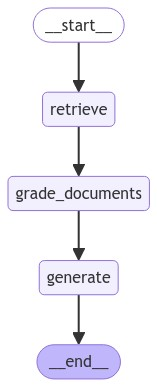

In [56]:
# Graph
workflow = StateGraph(GraphState)

# Nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)

# Edges
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [61]:
# Inference
def generate_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke(
        {"question": example["question"]}, config
    )
    return {"response": state_dict["response"], "documents": [doc.metadata["id"] for doc in state_dict["documents"]]}


example = {"question": "Who is Kachina"}
response = generate_answer(example)
print(response["response"])
print(response["documents"])

---RETRIEVE---
Retrieval time: 0.196 sec
---GRADE DOCUMENTS---
1.000 https://genshin-impact.fandom.com/wiki/Kachina#12
0.9 https://genshin-impact.fandom.com/wiki/Echoes_of_Life#32
1.000 https://genshin-impact.fandom.com/wiki/Kachina#13
0.000 https://genshin-impact.fandom.com/wiki/Kachina/Lore#11
0.000 https://genshin-impact.fandom.com/wiki/Kachina/Voice-Overs#19
0.900 https://genshin-impact.fandom.com/wiki/Kachina/Gallery#0
Grading time: 1.278 sec
---GENERATE---
Generation time: 2.492 sec
Kachina is a young warrior belonging to the Children of Echoes. She is determined to become strong in spite of the numerous failures she has experienced. As a playable Geo character in Genshin Impact, Kachina is known for her bravery and resilience.

She bears the Ancient Name of "Uthabiti", which suggests that she comes from a rich cultural heritage. Her affiliation with the Nanatzcayan people adds to her unique identity within the world of Teyvat.

Kachina's personality is shaped by her experiences 